In [1]:
# If needed, install deps (uncomment in Colab / fresh env)
!pip install -q datasets librosa soundfile pandas matplotlib numpy tqdm torchcodec

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from datasets import load_dataset
from IPython.display import Audio, display

from collections import Counter
import pandas as pd
import numpy as np
import ast  # for safe literal evaluation

import librosa
import librosa.display
import random

In [2]:
# Load as-is; we won't access rows that include 'audio' dicts to avoid TorchCodec
DATASET_ID = "vtsouval/mtg_jamendo_autotagging"
ds = load_dataset(DATASET_ID, split="train")

# Force raw python formatting for safe column-wise access
ds = ds.with_format("python")
ds

Dataset({
    features: ['audio', 'genre', 'instrument', 'mood_theme', 'duration', 'album_id', 'artist_id', 'track_id'],
    num_rows: 10516
})

In [3]:
# Basic stats
n_rows = ds.num_rows
durations = np.array(ds["duration"])

print(f"Rows: {n_rows}")
print(f"Duration (unique first 5): {np.unique(durations)[:5]} seconds (most are ~30s)")

cols_to_show = ["track_id", "album_id", "artist_id", "genre", "instrument", "mood_theme", "duration"]
preview_df = pd.DataFrame({c: ds[c][:5] for c in cols_to_show})
display(preview_df)



Rows: 10516
Duration (unique first 5): [30] seconds (most are ~30s)


,track_id,album_id,artist_id,genre,instrument,mood_theme,duration
0,948,149,87,"['downtempo', 'lounge', 'easylistening', 'chil...",['synthesizer'],['background'],30
1,950,149,87,"['techno', 'lounge', 'easylistening', 'chillou...",['synthesizer'],['background'],30
2,951,149,87,"['techno', 'lounge', 'ambient', 'easylistening...",['synthesizer'],['background'],30
3,6247,960,811,['soundtrack'],"['keyboard', 'trombone', 'cello']",['emotional'],30
4,6248,960,811,"['soundtrack', 'classical']",['piano'],['documentary'],30


In [4]:
def parse_instruments(x):
    """Ensure each entry is a list[str]. Handles stringified lists like "['piano','guitar']"."""
    if isinstance(x, list):
        return x
    if isinstance(x, str):
        try:
            parsed = ast.literal_eval(x)
            if isinstance(parsed, list):
                return parsed
            return [x]
        except (ValueError, SyntaxError):
            return [i.strip() for i in x.split(",") if i.strip()]
    return []

# Parse + normalize (lowercase, per-row dedup)
instruments_raw = [parse_instruments(tags) for tags in ds["instrument"]]
instruments_norm = [sorted(set(t.strip().lower() for t in tags if isinstance(t, str))) for tags in instruments_raw]

# Global frequency
from collections import Counter
instrument_counts = Counter(tag for tags in instruments_norm for tag in tags)
print(f"Unique instruments: {len(instrument_counts)}")

top20 = pd.DataFrame(instrument_counts.most_common(20), columns=["instrument", "count"])
display(top20)


Unique instruments: 41


,instrument,count
0,synthesizer,3509
1,piano,3480
2,drums,2496
3,bass,2179
4,electricguitar,1613
5,guitar,1444
6,keyboard,931
7,acousticguitar,877
8,violin,865
9,drummachine,730


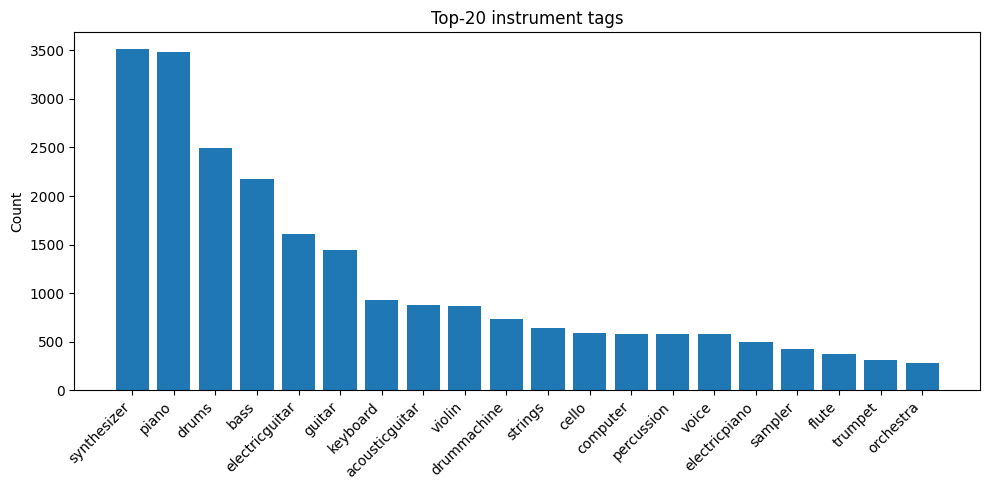

In [5]:
plt.figure(figsize=(10,5))
plt.bar(top20["instrument"], top20["count"])
plt.xticks(rotation=45, ha="right")
plt.ylabel("Count")
plt.title("Top-20 instrument tags")
plt.tight_layout()
plt.show()


In [6]:
PREFERRED = "drums"
TARGET_INSTRUMENT = PREFERRED if PREFERRED in instrument_counts else top20.iloc[0]["instrument"]
print("Target instrument:", TARGET_INSTRUMENT)

has_target = np.array([TARGET_INSTRUMENT in tags for tags in instruments_norm], dtype=bool)
pos_idx = np.where(has_target)[0].tolist()
neg_idx = np.where(~has_target)[0].tolist()
print(f"Positives: {len(pos_idx)}  |  Negatives: {len(neg_idx)}")

# Quick peek (safe: no 'audio' access)
sel = pos_idx[:8]
pos_df = pd.DataFrame({
    "track_id": np.asarray(ds["track_id"], dtype=object)[sel],
    "instruments": [instruments_norm[i] for i in sel],
    "genres": np.asarray(ds["genre"], dtype=object)[sel],
})
display(pos_df)


Target instrument: drums
Positives: 2496  |  Negatives: 8020


,track_id,instruments,genres
0,7391,"[bass, computer, drummachine, drums, electricg...","['chanson', 'pop', 'electronic']"
1,7394,"[acousticguitar, bass, computer, drummachine, ...","['downtempo', 'soundtrack', 'easylistening', '..."
2,7395,"[bass, computer, drummachine, drums, guitar, s...","['synthpop', 'pop', 'rock', 'electronic', 'pop..."
3,7396,"[cello, computer, drummachine, drums, electric...","['triphop', 'downtempo', 'choir', 'soundtrack'..."
4,7397,"[acousticguitar, bass, computer, drummachine, ...","['soundtrack', 'easylistening', 'pop', 'electr..."
5,7400,"[bass, cello, computer, drummachine, drums, ke...","['downtempo', 'soundtrack', 'choir', 'orchestr..."
6,7401,"[bass, cello, computer, drummachine, drums, ke...","['soundtrack', 'orchestral', 'easylistening', ..."
7,9592,"[acousticguitar, bass, drums, electricguitar, ...","['pop', 'indie', 'alternative']"


In [7]:
# We avoid any HF audio decoding by reading the underlying Arrow table directly.
import pyarrow.compute as pc

def get_audio_basenames_from_dataset(dataset):
    # 'audio' column is a struct with a 'path' (often just a basename in this dataset)
    col = dataset._data.column(dataset._data.schema.get_field_index("audio"))  # ChunkedArray
    try:
        path_chunked = pc.struct_field(col, "path")  # ChunkedArray[str]
        return path_chunked.to_pylist()
    except Exception:
        # Fallback: iterate chunks
        names = []
        for chunk in col.chunks:
            names.extend(chunk.field("path").to_pylist())
        return names

audio_names = get_audio_basenames_from_dataset(ds)
print("Example stored name:", audio_names[0])


Example stored name: 948.low.mp3


In [8]:
from huggingface_hub import hf_hub_download
import os

def resolve_audio_path(name_or_path, repo_id=DATASET_ID):
    """
    Return an absolute, existing path for the audio file.
    - If name_or_path is an absolute existing path, return it.
    - Otherwise, try to download from the dataset repo (common layout: 'audio/<basename>').
    """
    if isinstance(name_or_path, str) and os.path.isabs(name_or_path) and os.path.exists(name_or_path):
        return name_or_path

    basename = os.path.basename(str(name_or_path))
    tries = [f"audio/{basename}", basename]

    last_err = None
    for rel in tries:
        try:
            local = hf_hub_download(repo_id=repo_id, filename=rel)
            if os.path.exists(local):
                return local
        except Exception as e:
            last_err = e
            continue
    raise FileNotFoundError(f"Could not resolve audio file: {name_or_path} (last error: {last_err})")

# Build a list of absolute local paths you can feed to librosa
audio_paths = [resolve_audio_path(n) for n in audio_names]
print("Resolved example path:", audio_paths[0])


FileNotFoundError: Could not resolve audio file: 948.low.mp3 (last error: 401 Client Error. (Request ID: Root=1-68e7a998-5884d325464953f711f33962;6d540972-fac2-4ed2-95d1-99779e4a3763)

Repository Not Found for url: https://huggingface.co/vtsouval/mtg_jamendo_autotagging/resolve/main/948.low.mp3.
Please make sure you specified the correct `repo_id` and `repo_type`.
If you are trying to access a private or gated repo, make sure you are authenticated. For more details, see https://huggingface.co/docs/huggingface_hub/authentication
Invalid username or password.)

In [ ]:
from IPython.display import Audio, display
import librosa
import librosa.display

def load_audio_by_index(i, target_sr=None, mono=True):
    """Load audio by index using librosa (no TorchCodec)."""
    path = audio_paths[i]
    y, sr = librosa.load(path, sr=target_sr, mono=mono)
    return y, sr, path

def show_and_play(y, sr, title=None, show_plot=True):
    """Waveform preview + an audio player."""
    if show_plot:
        plt.figure(figsize=(10, 2.8))
        librosa.display.waveshow(y, sr=sr)
        plt.title(title if title else "Waveform")
        plt.tight_layout()
        plt.show()
    display(Audio(y, rate=sr))


In [ ]:
K = 3
random.shuffle(pos_idx)
pos_pick = pos_idx[:min(K, len(pos_idx))]
print(f"Playing {len(pos_pick)} positive samples for '{TARGET_INSTRUMENT}':")

for i in pos_pick:
    y, sr, path = load_audio_by_index(i)
    title = f"track_id={ds['track_id'][i]} | target={TARGET_INSTRUMENT} | sr={sr}"
    show_and_play(y, sr, title=title)

    # Optional: log-mel spectrogram
    S = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=1024, hop_length=256, n_mels=128)
    S_db = librosa.power_to_db(S, ref=np.max)
    plt.figure(figsize=(10,4))
    librosa.display.specshow(S_db, sr=sr, x_axis="time", y_axis="mel")
    plt.colorbar(format="%+2.0f dB")
    plt.title("Log-Mel Spectrogram")
    plt.tight_layout()
    plt.show()


In [ ]:
K = 3
random.shuffle(neg_idx)
neg_pick = neg_idx[:min(K, len(neg_idx))]
print(f"Playing {len(neg_pick)} negative samples (no '{TARGET_INSTRUMENT}'):")

for i in neg_pick:
    y, sr, path = load_audio_by_index(i)
    title = f"track_id={ds['track_id'][i]} | no target | sr={sr}"
    show_and_play(y, sr, title=title)

    # Optional: log-mel spectrogram
    S = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=1024, hop_length=256, n_mels=128)
    S_db = librosa.power_to_db(S, ref=np.max)
    plt.figure(figsize=(10,4))
    librosa.display.specshow(S_db, sr=sr, x_axis="time", y_axis="mel")
    plt.colorbar(format="%+2.0f dB")
    plt.title("Log-Mel Spectrogram")
    plt.tight_layout()
    plt.show()
